In [314]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
le = LabelEncoder()

In [315]:
# # grid search cv param
param_grid = {
    'learning_rate': [0.05],
    'max_depth': [7],
    'n_estimators': [300],
    'subsample': [0.8], 
    'colsample_bytree': [1.0],
    'lambda': [1],
}

# xgb param
xgb_params = {
    'random_state': 42,
    'objective' :'reg:squarederror'
}

In [316]:
# Read the data into a pandas DataFrame
df = pd.read_csv('CodeChallenge_Dataset_2021-2023_Set 1.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'].str.split().str[0])

# Group by 'Date' and 'ProductId', and sum the 'Amount' column
df = df.groupby(['Date', 'ProductId'])['Amount'].sum().reset_index()
df['ProductId'] = le.fit_transform(df['ProductId'])
df = df.set_index('Date')
df[:10]

,ProductId,Amount
Date,,
2021-01-02,200,6.776567e+07
2021-01-04,200,1.850023e+08
2021-01-05,200,1.109591e+08
2021-01-06,200,2.851943e+07
2021-01-07,200,5.925216e+06
2021-01-08,200,7.354445e+07
2021-01-09,200,8.794375e+04
2021-01-11,200,1.277867e+08
2021-01-12,200,6.012206e+07


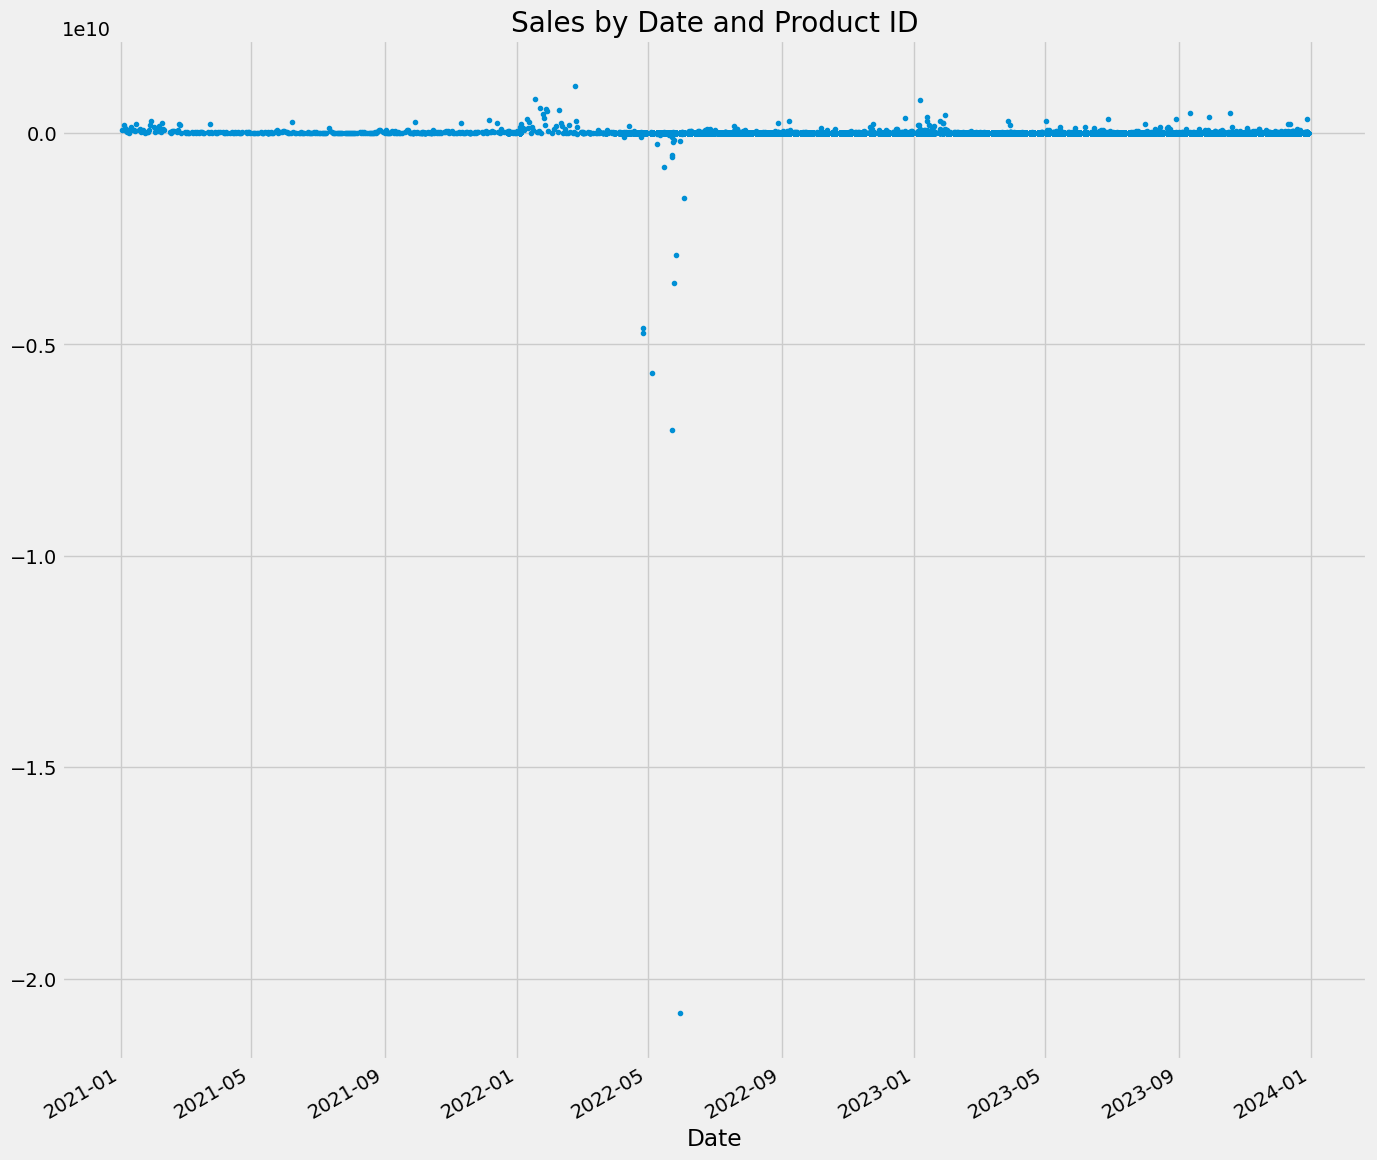

In [317]:
df['Amount'].plot(style='.',
        figsize=(15, 15),
        color=color_pal[0],
        title='Sales by Date and Product ID')
plt.savefig('D:/programming/sales prediction/result/before_processing.png')
plt.show()

In [318]:
# remove the negative value which is the outlier
df = df[df['Amount'] >= 0]

In [319]:
# Outlier detection using IQR
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df = df[~((df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR)))]


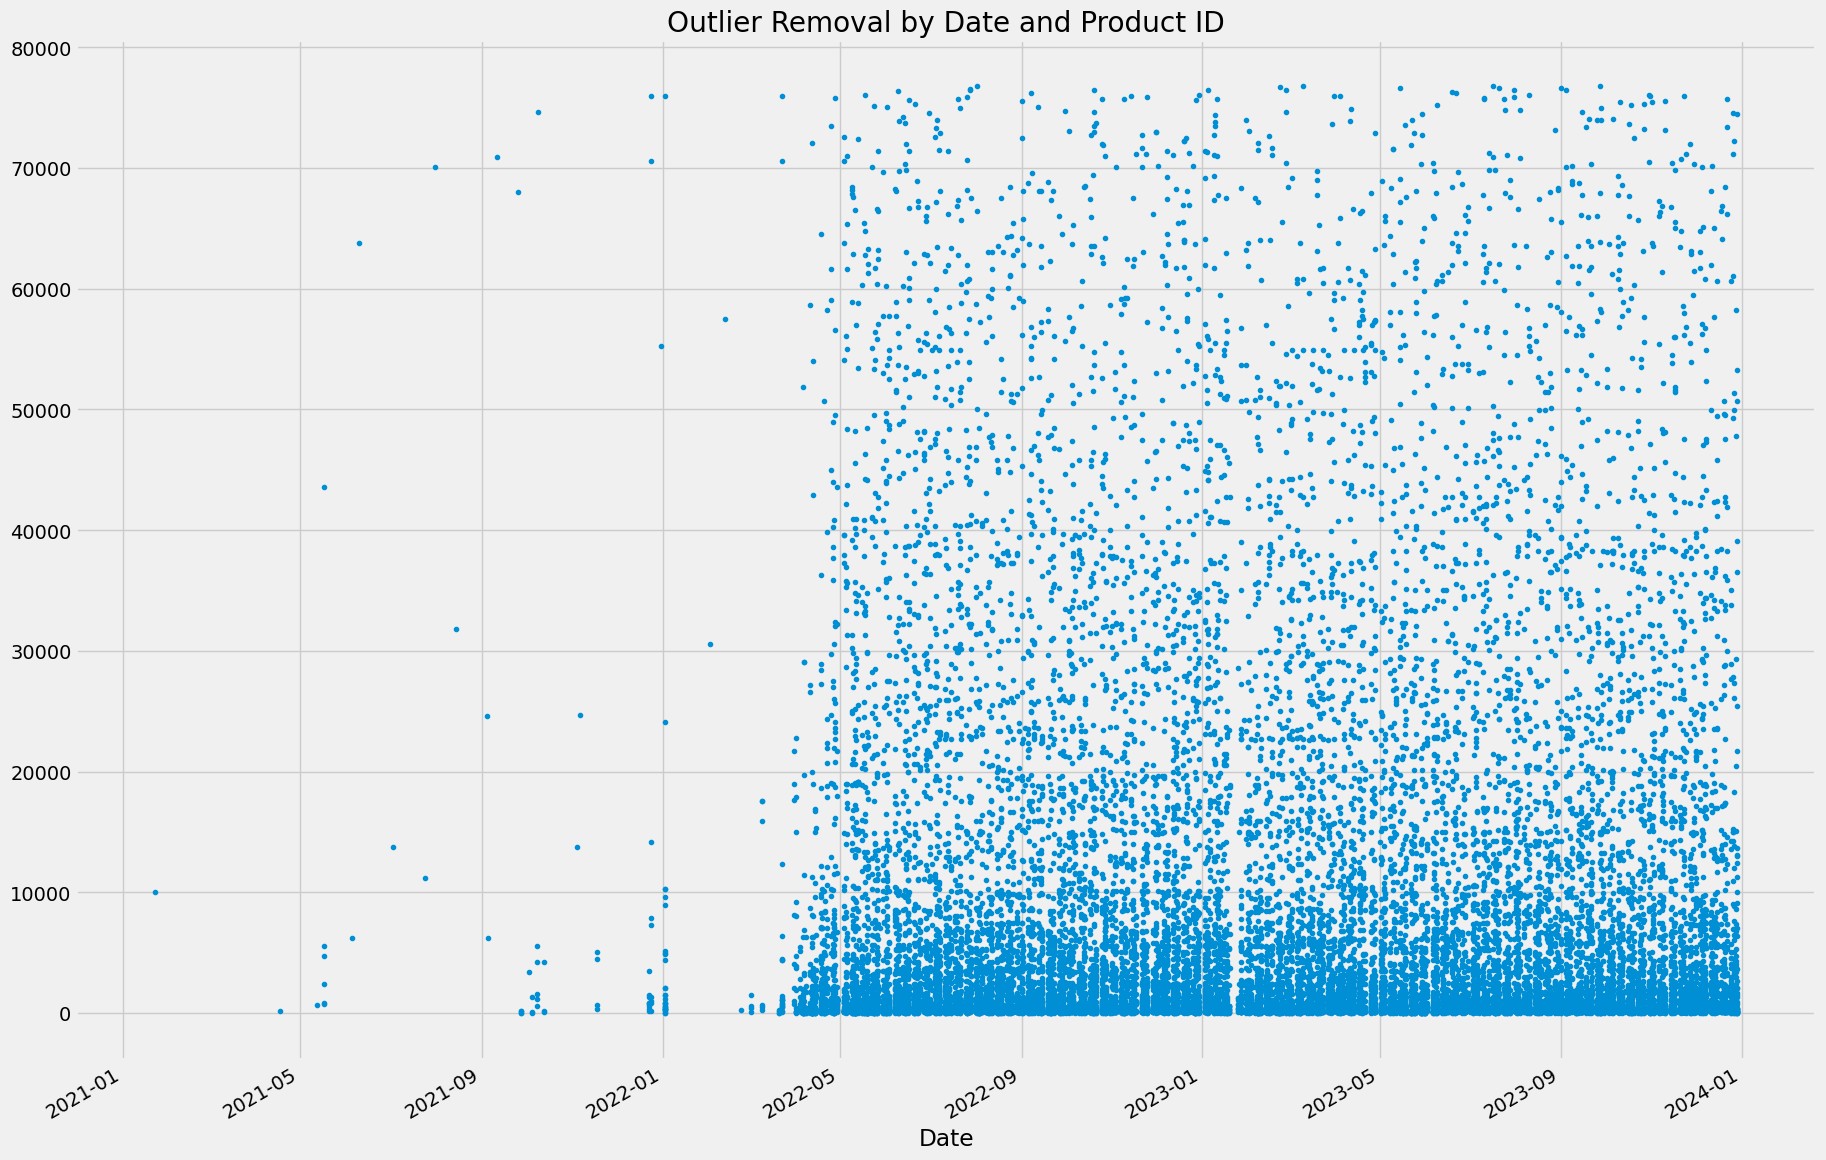

In [320]:
df['Amount'].plot(style='.',
        figsize=(20, 15),
        color=color_pal[0],
        title='Outlier Removal by Date and Product ID')
plt.savefig('D:/programming/sales prediction/result/after_processing.png')
plt.show()

In [321]:
len(df)

20194

In [322]:
# us_holidays = holidays.US()
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week
df['is_month_end'] = df.index.is_month_end.astype(int)
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['weekday_month_interaction'] = df['weekday'] * df['month']
# df['is_holiday'] = [1 if x in us_holidays else 0 for x in df.index]


In [323]:
df['Amount_lag_1'] = df['Amount'].shift(1)  # Sales from the previous day
df['Amount_lag_7'] = df['Amount'].shift(7)  # Sales from 7 days ago
df['Amount_lag_14'] = df['Amount'].shift(14)  # Sales from 14 days ago
df['Amount_lag_30'] = df['Amount'].shift(30)  # Sales from previous month
df['Amount_lag_180'] = df['Amount'].shift(180)  # Sales from half year
df['Amount_rolling_mean_3'] = df['Amount'].rolling(window=3).mean()  # 3-day rolling mean
df['Amount_rolling_mean_7'] = df['Amount'].rolling(window=7).mean()  # 7-day rolling mean
df['Amount_rolling_mean_14'] = df['Amount'].rolling(window=14).mean()  # 14-day rolling mean
df['Amount_rolling_mean_30'] = df['Amount'].rolling(window=30).mean()  # 30-day rolling mean
df['Amount_rolling_mean_180'] = df['Amount'].rolling(window=180).mean()  # 30-day rolling mean
df['ema_3'] = df['Amount'].ewm(span=3).mean()
df['ema_7'] = df['Amount'].ewm(span=7).mean()
df['ema_14'] = df['Amount'].ewm(span=14).mean()
df['ema_30'] = df['Amount'].ewm(span=30).mean()
df['ema_180'] = df['Amount'].ewm(span=180).mean()

# Cumulative sales trend
df['cumulative_sales'] = df['Amount'].cumsum()

In [324]:
df.fillna(0, inplace=True)

In [325]:
columns = [col for col in df.columns if col != 'Amount']

In [326]:
# Step 2: Define feature columns and target
X = df[columns]  # Features based on the date
y = df['Amount']  # Target variable (sales amount)

In [327]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# X_train, X_test = X[X.index < '2023-01-01'], X[X.index >= '2023-01-01']
# y_train, y_test = y[X.index < '2023-01-01'], y[X.index >= '2023-01-01']

In [328]:
# Step 4: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [329]:
len(X_train)

16155

In [330]:
len(X_test)

4039

In [331]:
xgb_model = xgb.XGBRegressor(
    **xgb_params
)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [1.0], 'lambda': [1],
                         'learning_rate': [0.05], 'max_depth': [7],
                         'n_estimators': [300], 'subsample': [0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [332]:
# Step 6: Use the best model from the grid search to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Step 7: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Best Parameters: {grid_search.best_params_}")
print(f"RMSE: {rmse}")

# rmse 1 - 790.6659721083591
# rmse 2 - 137.43643486903306
# rmse 3 - 138.63130912770134
# rmse 4 - 137.43643486903306
# rmse 5 - 136.89837092921255
# rmse 6 - 132.55066763253126
# rmse 7 - 131.68950070727695

# rmse 1 - 1326.519855448006
# rmse 2 - 1320.6775393651578

Best Parameters: {'colsample_bytree': 1.0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
RMSE: 1320.6775393651578


In [333]:
# Set up eval_set for training and validation metrics
eval_set = [(X_train, y_train), (X_test, y_test)]
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Retrieve evaluation results
results = best_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

[0]	validation_0-rmse:14769.13846	validation_1-rmse:14669.73130
[1]	validation_0-rmse:14067.24757	validation_1-rmse:13981.47258
[2]	validation_0-rmse:13401.53548	validation_1-rmse:13326.51580
[3]	validation_0-rmse:12769.25864	validation_1-rmse:12701.07643
[4]	validation_0-rmse:12166.61629	validation_1-rmse:12110.71442
[5]	validation_0-rmse:11593.88861	validation_1-rmse:11552.90089
[6]	validation_0-rmse:11049.41042	validation_1-rmse:11020.84507
[7]	validation_0-rmse:10534.54055	validation_1-rmse:10517.01476
[8]	validation_0-rmse:10045.24177	validation_1-rmse:10034.84333
[9]	validation_0-rmse:9579.02094	validation_1-rmse:9577.61354
[10]	validation_0-rmse:9135.70928	validation_1-rmse:9142.99980
[11]	validation_0-rmse:8712.77339	validation_1-rmse:8730.18473
[12]	validation_0-rmse:8310.35215	validation_1-rmse:8337.10043
[13]	validation_0-rmse:7929.54907	validation_1-rmse:7963.87697
[14]	validation_0-rmse:7567.01410	validation_1-rmse:7608.03327
[15]	validation_0-rmse:7221.55515	validation_1-

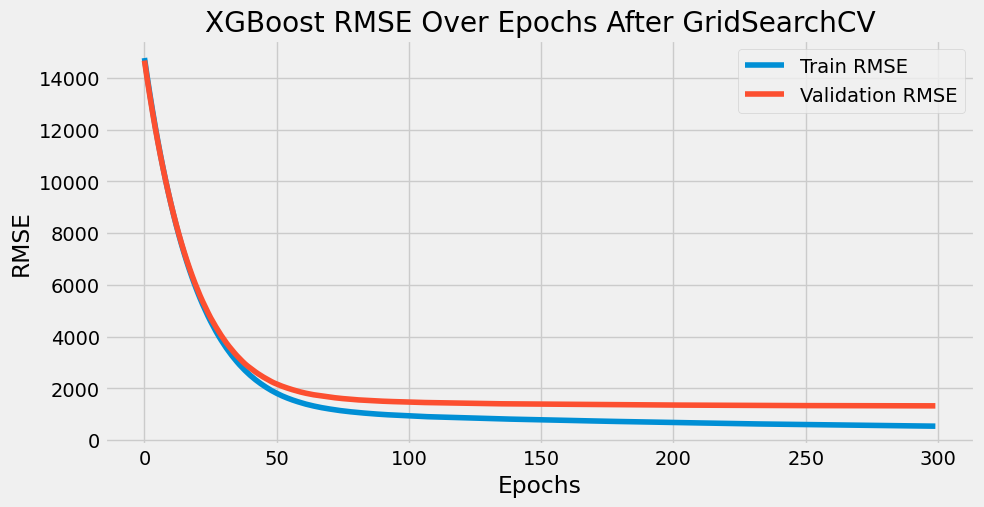

In [334]:
# Plot RMSE
plt.figure(figsize=(10,5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Epochs After GridSearchCV')
plt.legend()
plt.savefig('D:/programming/sales prediction/result/model_training.png')
plt.show()

In [335]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, ...)